In [75]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from glob import glob
import os

from matplotlib import cm
import seaborn as sns
from tqdm.notebook import tqdm_notebook, tqdm

import json
import pickle
import itertools
from scipy import stats

In [82]:
rel_data_dir_full = './data/sharew8_all/'
rel_data_dir_easy = './data/sharew8_easy/'
outdir = './Project'
plotdir ='./plots'

In [4]:
'''
Wave 8 Release 8.0.0
DOI: 10.6103/SHARE.w8.800
2022-02-10 00:53:53
'''
all_files = glob(f"{rel_data_dir_full}*.dta")

'''
easySHARE Release 8.0.0
DOI: 10.6103/SHARE.easy.800
2022-02-10 01:00:22
'''
easy_files = glob(f"{rel_data_dir_easy}*.dta")

'''
Wave 8 Accelerometer Epochs Release 8.0.0
DOI: 10.6103/SHARE.w8.800
2022-02-10 01:04:04
'''
acc_files = glob(f"{rel_data_dir_full}dta/**/*.dta", recursive=True)

Loading the datasets from SHARE 

In [5]:
df_easy = pd.read_stata(easy_files[0])
df_ph = pd.read_stata(os.path.join(rel_data_dir_full, 'sharew8_rel8-0-0_ph.dta'))
df_acc_hr = pd.read_stata(os.path.join(rel_data_dir_full, 'sharew8_rel8-0-0_gv_accelerometer_hour.dta'))
df_acc = pd.read_stata(os.path.join(rel_data_dir_full, 'sharew8_rel8-0-0_gv_accelerometer_total.dta'))
df_acc_imp = pd.read_stata(os.path.join(rel_data_dir_full, 'sharew8_rel8-0-0_gv_imputations.dta'))
df_acscore = pd.read_stata(os.path.join(rel_data_dir_full, 'sharew8_rel8-0-0_br.dta'))
df_acc_hr_clean = df_acc_hr.iloc[:,0:15]

Data prep

In [6]:
df_acc_hr_clean.loc[:, 'OxCGRT_stay_at_home'] = df_acc_hr_clean['OxCGRT_stay_at_home'].replace({
    'No measures': 'No restrictions',
    "Require not leaving house with exceptions for daily exercise, grocery shopping, and 'essential' trips": 'Essential only',
    "Recommend not leaving house": 'Stay at home',
})

In [7]:
def get_common_columns(df1, df2, merge_on=['mergeid']):
    common = df1.columns.difference(df2.columns).tolist()
    common.extend(merge_on)
    return common

In [8]:
df = df_acc_hr_clean.copy()
df = pd.merge(left=df, left_on=['mergeid'], right=df_ph[get_common_columns(df_ph, df)], right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df_acc[get_common_columns(df_acc, df)], right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df_easy[get_common_columns(df_easy, df)], right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df_acscore[get_common_columns(df_acscore, df)], right_on=['mergeid'], how='left')
df = df[df['wave'] == 8]

In [9]:
def map_selected_num(df, columns: list[str]):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].map({
            'Selected': 1,
            'Not selected': 0,
            "Don't know": -1,
            'Refusal': -2,
            1: 1,
            0: 0,
            -1: -1,
            -2: -2,
        })
    return df

def map_bmi_num(df, columns: list[str] = ['bmi']):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].replace({
            '-15. no information': -1,
            '-13. not asked in this wave': -1,
            "-12. don't know / refusal": -1,
            '-3. implausible value/suspected wrong': -1,
        })
        df[c] = df[c].astype(float)
    return df

def map_freq_num(df, columns:list[str]):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].replace({
            'More than once a week': 1,
            'Once a week': 2,
            'One to three times a month': 3,
            'Hardly ever, or never': 4,
            "Don't know": -1,
            'Refusal' : -1,
            '1. More than once a week': 1,
            '2. Once a week': 2,
            '3. One to three times a month': 3,
            '4. Hardly ever, or never': 4,
            "5. Don't know": -1,
            '6. Refusal' : -1,
            '-15. no information': -1,
            '-13. not asked in this wave': -1,
            "-12. don't know / refusal": -1,
            '-10. SHARELIFE interview': -1,
        })
        df[c] = df[c].astype(float)
    return df

In [10]:
#                        Hypertension, Diabetis, Osteoarthritis, pain hips, pain knee
df = map_selected_num(df, ['ph006d2', 'ph006d5', 'ph006d20', 'ph087d2', 'ph087d3'])
df = map_bmi_num(df)
df = map_freq_num(df, ['br015_', 'br016_'])   
df['br015_'].value_counts()

4.0    68400
1.0    47088
2.0    22416
3.0    15696
Name: br015_, dtype: int64

In [11]:
df['female'] = pd.to_numeric(df['female'].replace({'1. female': 1, '0. male': 0}))
df.loc[:, 'age'] = df.replace({'-15. no information': -1})
df.loc[:, 'age'] = df['age'].astype(float)

Defining Osteoarthritis 

ph006d20: Osteoarthritis/other rheumatism: ever diagnosed/currently having

ph087d2: Pain location: hips or
ph087d3: Pain location: knees

In [12]:
df['ph006d2'] = pd.to_numeric(df['ph006d2'])
df['ph006d5'] = pd.to_numeric(df['ph006d5'])

df['OA'] = np.where(((df['ph006d20'] == 1) & (df['ph087d2'] == 1)) | ((df['ph006d20'] == 1) & (df['ph087d3'] == 1)), int(1), int(0))
df['Hypertension'] = np.where(df['ph006d2'] == 1, int(1), int(0))
df['Diabetes'] = np.where(df['ph006d5'] == 1, int(1), int(0))
df['control'] = np.where((df['Hypertension'] == 0) & (df['OA'] == 0) & (df['OA'] == 0), int(1), int(0))

In [13]:
df['disease']  = df[['Hypertension', 'Diabetes', 'OA', 'control',]].apply(lambda x: x.idxmax(), axis=1)
df['disease'].value_counts()

control         68352
Hypertension    67656
Diabetes         8976
OA               8616
Name: disease, dtype: int64

Self-reported activity score

0-1: very low

2-3: moderately low

4-7: moderately high

8-9: high

In [68]:
df['activity'] = 2*(4-df['br015_']) + (4-df['br016_'])
df['activity'].value_counts()

9.0    36888
3.0    34416
7.0    15912
0.0    12096
2.0     9840
5.0     8640
1.0     6552
6.0     4104
4.0     3840
8.0     3744
Name: activity, dtype: int64

In [15]:
df.drop(df[df.measurementday > 7].index, inplace=True)

In [16]:
vars = ['mergeid', 'female', 'age', 'bmi','activity', 'GGIR_mean_ENMO_hour','GGIR_N_valid_hours','hour','measurementday','weekday','month',
        'year','device_id', 'frequency', 'position', 'country','disease', 'Hypertension', 'Diabetes', 'OA']
df_stat = df[vars].copy()
df_stat.rename(columns={'GGIR_mean_ENMO_hour': 'ENMO_hour'}, inplace=True)

In [17]:
def calc_ENMO_stats(df, enmo_col='ENMO_hour'):
    df = df.copy()
    mean = df.groupby('mergeid')[enmo_col].mean()
    median = df.groupby('mergeid')[enmo_col].median()
    var = df.groupby('mergeid')[enmo_col].var()
    mean.name = 'mean_ENMO'
    median.name = 'median_ENMO'
    var.name = 'var_ENMO'
    df = pd.merge(left=df, left_on='mergeid', right=mean, right_on='mergeid', how='left')
    df = pd.merge(left=df, left_on='mergeid', right=median, right_on='mergeid', how='left')
    df = pd.merge(left=df, left_on='mergeid', right=var, right_on='mergeid', how='left')
    return df

In [18]:
df_stat= calc_ENMO_stats(df_stat)   
df_stat = df_stat.drop_duplicates(subset='mergeid', keep='first')
cols = ['ENMO_hour','GGIR_N_valid_hours','measurementday', 'hour', 'weekday']
df_stat.drop(cols, inplace=True, axis=1)
df_stat.head(5)

,mergeid,female,age,bmi,activity,month,year,device_id,frequency,position,country,disease,Hypertension,Diabetes,OA,mean_ENMO,median_ENMO,var_ENMO
0,Bf-031257-01,0,67.000000,21.155294,9.0,February,2020,68652.0,50,Left,Belgium,control,0,0,0,12.164127,9.664236,119.962879
168,Bf-043946-02,1,57.299999,38.446751,2.0,February,2020,30920.0,50,Left,Belgium,Hypertension,1,0,0,13.780020,8.492361,209.996045
336,Bf-073169-01,0,72.500000,25.209202,9.0,March,2020,68652.0,50,Right,Belgium,Hypertension,1,0,0,16.090929,11.452292,537.459251
504,Bf-227520-04,0,56.099998,24.593210,2.0,March,2020,17212.0,50,Right,Belgium,Hypertension,1,0,0,11.543128,11.326111,74.794850
552,Bf-286437-02,1,68.099998,30.778702,1.0,February,2020,54007.0,50,Right,Belgium,Hypertension,1,0,0,38.811152,48.127569,367.199181


ANOVA Self-reported activity score

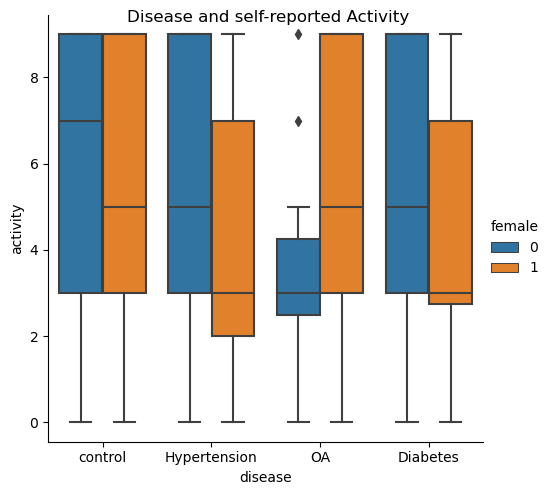

In [85]:
#df_stat.boxplot(column='activity', by='disease')
g = sns.catplot(data=df_stat, x='disease', y='activity', kind="box", hue='female')
g.fig.suptitle('Disease and self-reported Activity')
plt.savefig(os.path.join(plotdir, 'Boxplot_Disease_Activity.png'))
plt.show()

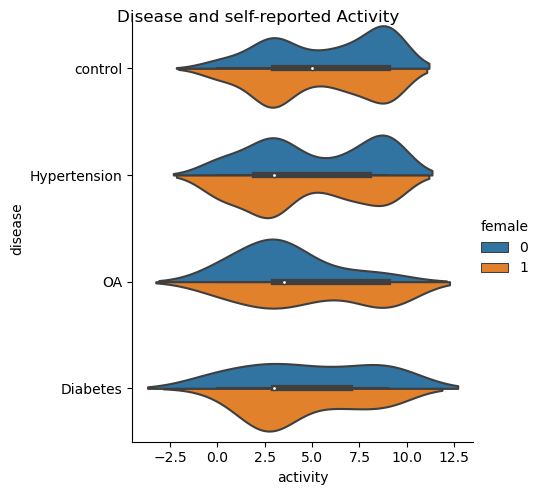

In [86]:
#combination of kernel density and boxplot
g = sns.catplot(
    data=df_stat, x="activity", y="disease", hue="female", kind="violin", split=True,
)

g.fig.suptitle('Disease and self-reported Activity')
plt.savefig(os.path.join(plotdir, 'KDE-BOX_Disease_Activity.png'))
plt.show()

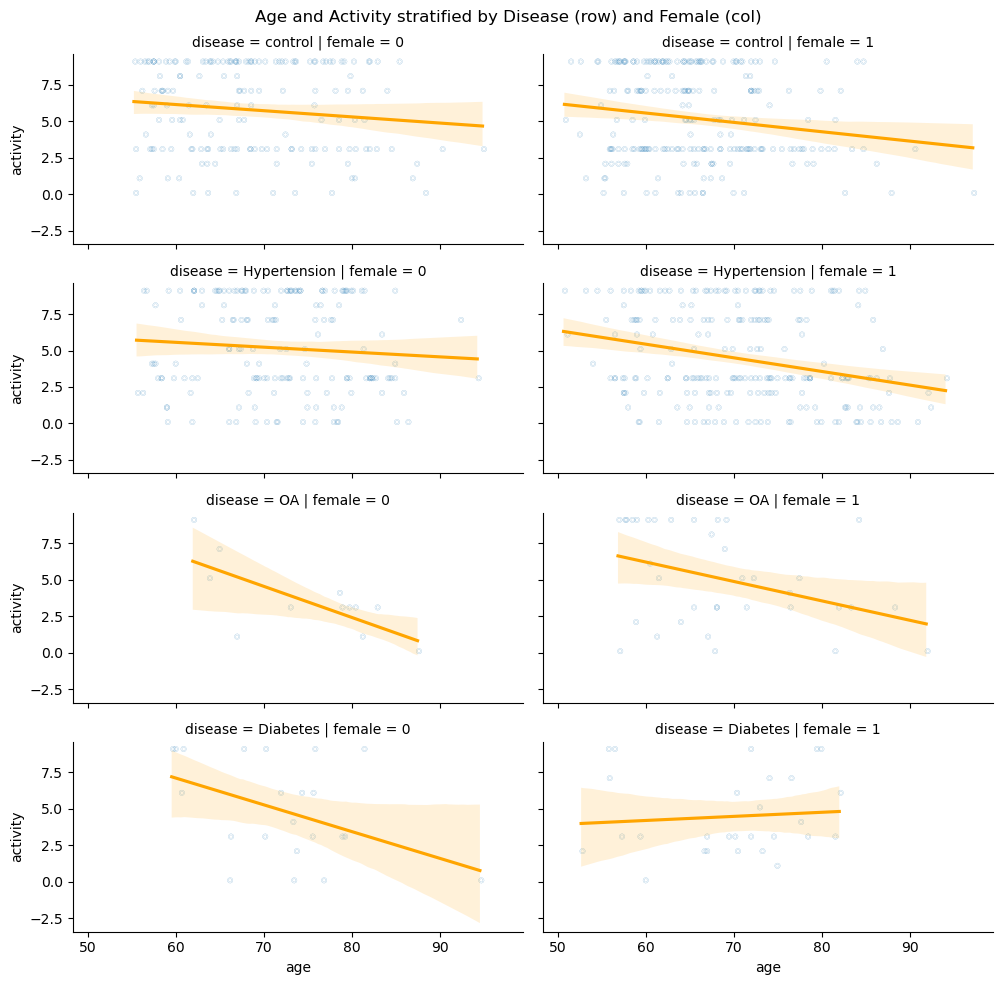

In [87]:
xs = ['age'] 
ys = ['activity']
rows = ['disease']
cols = ['female']

for (x,y,row,col) in itertools.product(*[xs, ys, rows, cols]):
    g = sns.lmplot(data=df_stat, 
                col=col, row=row, x=x, y=y, 
                markers="$\circ$", line_kws={'color': 'orange'}, scatter_kws={'lw':0.1, 'facecolor':'none', 'alpha':1},
                #fit_reg=False,
                height=2.5, aspect=2)
    g.fig.suptitle(f'{x.capitalize()} and {y.capitalize()} stratified by {row.capitalize()} (row) and {col.capitalize()} (col)')

    g.tight_layout()
    plt.savefig(os.path.join(plotdir, f"{'_'.join(['lmplot',x,y,row,col])}.png"))
    plt.show()

ANOVA (Disease: true/false)

In [21]:
import scipy.stats as stats
H_E = df_stat[df_stat['Hypertension']==1]['var_ENMO']
_H_E = df_stat[df_stat['Hypertension']==0]['var_ENMO']
D_E = df_stat[df_stat['Diabetes']==1]['var_ENMO']
_D_E = df_stat[df_stat['Diabetes']==0]['var_ENMO']
OA_E = df_stat[df_stat['OA']==1]['var_ENMO']
_OA_E = df_stat[df_stat['OA']==0]['var_ENMO']

In [22]:
stats.f_oneway(H_E, _H_E)

F_onewayResult(statistic=4.629038511898304, pvalue=0.03171499229619758)

In [23]:
stats.f_oneway(D_E, _D_E)

F_onewayResult(statistic=0.17350982539044624, pvalue=0.6771158378345912)

In [24]:
stats.f_oneway(OA_E, _OA_E)

F_onewayResult(statistic=2.7791564286741655, pvalue=0.0958651054046013)

In [22]:
H_A = df_stat[df_stat['Hypertension']==1]['activity']
_H_A = df_stat[df_stat['Hypertension']==0]['activity']
D_A = df_stat[df_stat['Diabetes']==1]['activity']
_D_A = df_stat[df_stat['Diabetes']==0]['activity']
OA_A = df_stat[df_stat['OA']==1]['activity']
_OA_A = df_stat[df_stat['OA']==0]['activity']

In [26]:
stats.f_oneway(H_A, _H_A)

F_onewayResult(statistic=6.321811840631495, pvalue=0.012108970978511994)

In [27]:
stats.f_oneway(D_A, _D_A)

F_onewayResult(statistic=8.376412578644514, pvalue=0.0038980108521806814)

In [28]:
stats.f_oneway(OA_A, _OA_A)

F_onewayResult(statistic=3.453588730942582, pvalue=0.06345848641785197)

Regression

post-hoc with self-reported score

In [98]:
import pingouin as pg
from pingouin import pairwise_ttests

#supposing equal variance
posthoc = pairwise_ttests(dv='activity', between='disease', padjust='bonf', data=df_stat, correction=False)
posthoc.to_excel('post-hoc.xlsx', sheet_name='bonf_correct')
posthoc

c:\Users\mjbur\anaconda3\lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,disease,Diabetes,Hypertension,False,True,-0.197292,423.0,two-sided,0.843694,1.000000,bonf,0.166,-0.029650
1,disease,Diabetes,OA,False,True,-0.043502,96.0,two-sided,0.965392,1.000000,bonf,0.213,-0.008722
2,disease,Diabetes,control,False,True,-1.745300,431.0,two-sided,0.081645,0.489872,bonf,0.668,-0.261983
3,disease,Hypertension,OA,False,True,0.136751,421.0,two-sided,0.891293,1.000000,bonf,0.167,0.020926
4,disease,Hypertension,control,False,True,-3.092813,756.0,two-sided,0.002056,0.012334,bonf,8.632,-0.224462
5,disease,OA,control,False,True,-1.645595,429.0,two-sided,0.100580,0.603477,bonf,0.579,-0.251525


In [91]:
# supposing unequal variance 
pg.pairwise_gameshowell(dv='activity', between='disease', data=df_stat)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Diabetes,Hypertension,4.660000,4.754667,-0.094667,0.462597,-0.204642,64.249024,0.996937,-0.029650
1,Diabetes,OA,4.660000,4.687500,-0.027500,0.632781,-0.043459,95.250442,0.999970,-0.008722
2,Diabetes,control,4.660000,5.454308,-0.794308,0.458782,-1.731341,62.200513,0.316449,-0.261983
3,Hypertension,OA,4.754667,4.687500,0.067167,0.491087,0.136771,59.684207,0.999076,0.020926
4,Hypertension,control,4.754667,5.454308,-0.699641,0.226354,-3.090914,751.288596,0.011109,-0.224462
5,OA,control,4.687500,5.454308,-0.766808,0.487495,-1.572955,57.987644,0.401857,-0.251525


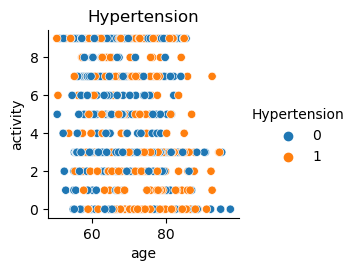

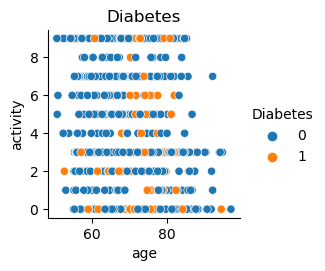

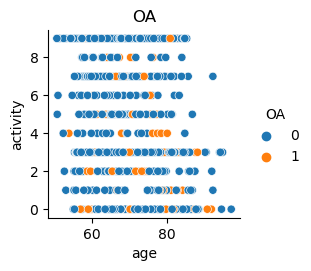

In [47]:
for d in ['Hypertension', 'Diabetes', 'OA']:
    sns.pairplot(df_stat,x_vars=['age'],y_vars=['activity'],hue=d)
    plt.title(f'{d}')
    plt.show()

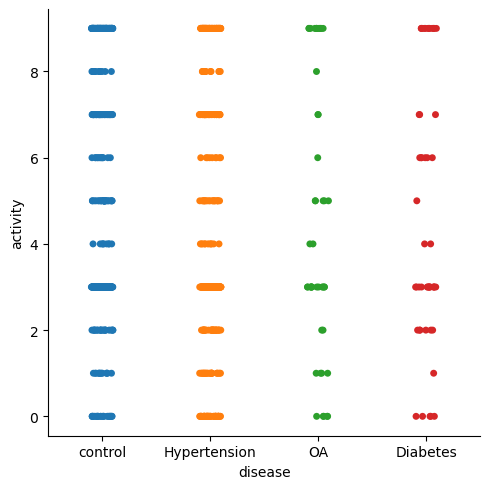

In [54]:
sns.catplot(data=df_stat, x="disease", y="activity")
plt.show()

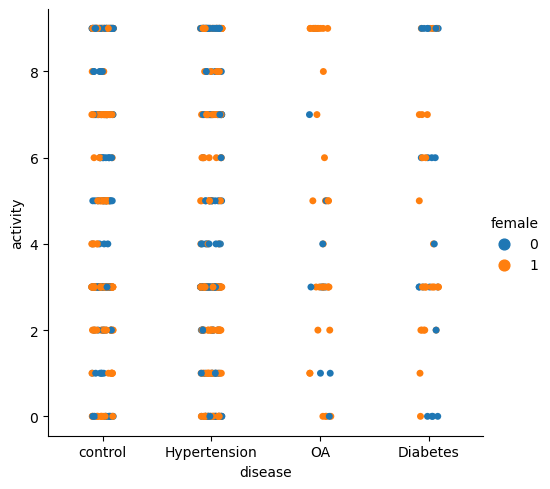

In [57]:
sns.catplot(data=df_stat, x="disease", y="activity", hue="female")
plt.show()

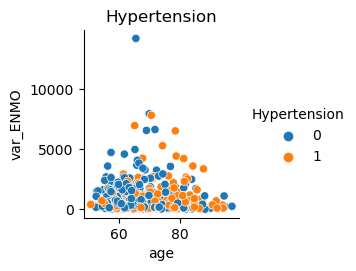

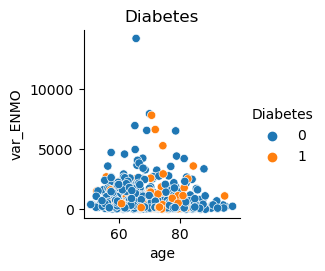

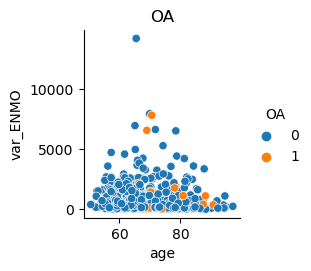

In [95]:
for d in ['Hypertension', 'Diabetes', 'OA']:
    sns.pairplot(df_stat,x_vars=['age'],y_vars=['var_ENMO'],hue=d)
    plt.title(f'{d}')
    plt.show()

In [74]:
def qqplot(data, x, y, hue=None, palette='viridis', figsize=[6,6], *args, **kwargs):

    fig = plt.figure(figsize=figsize)
    if hue != None:
        for h,df in data.sort_values([hue]).groupby(by=hue, ):
            _, xr = stats.probplot(df[x].to_list(), fit=False)
            _, yr = stats.probplot(df[y].to_list(), fit=False)
            
            sns.scatterplot(x=xr, y=yr, label=h, edgecolor="none", palette=palette, *args, *kwargs)
    else:
        _, xr = stats.probplot(data[x].to_list(), fit=False)
        _, yr = stats.probplot(data[y].to_list(), fit=False)
        
        sns.scatterplot(x=xr, y=yr, edgecolor="none", palette=palette, *args, *kwargs)
        
    return fig

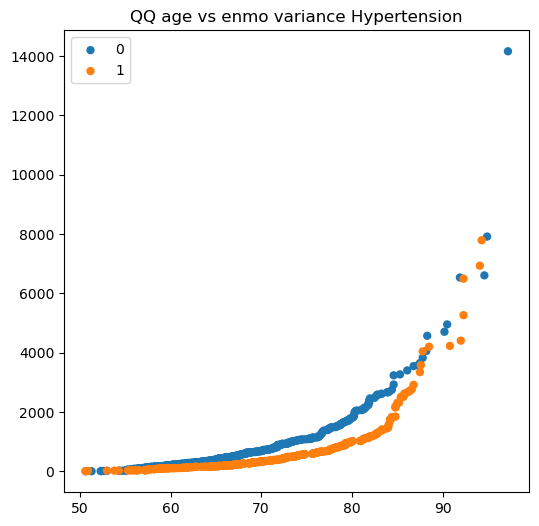

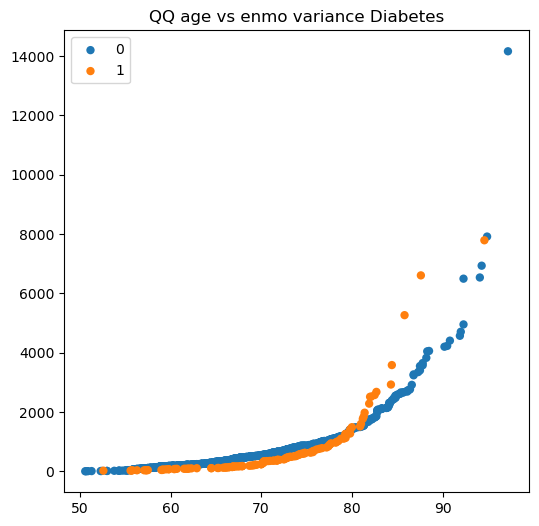

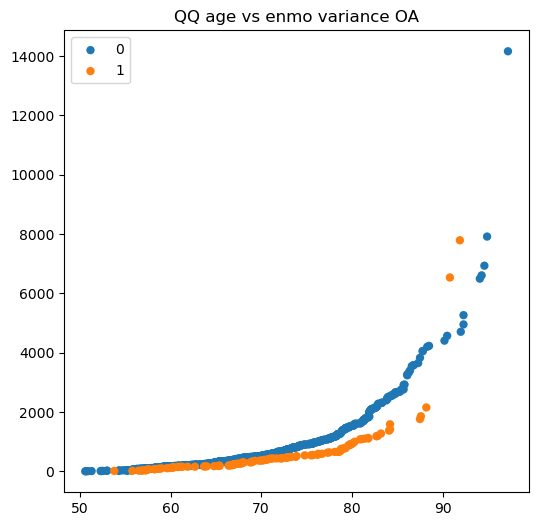

In [90]:
for d in ['Hypertension', 'Diabetes', 'OA']:
    _df = df_stat.dropna(subset=[d, 'age', 'var_ENMO'])
    p = qqplot(data=_df, x='age', y='var_ENMO', hue=d)
    plt.title(f'QQ age vs enmo variance {d}')
    plt.show()

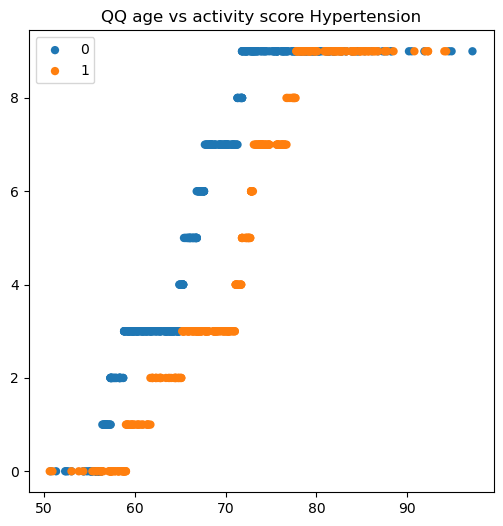

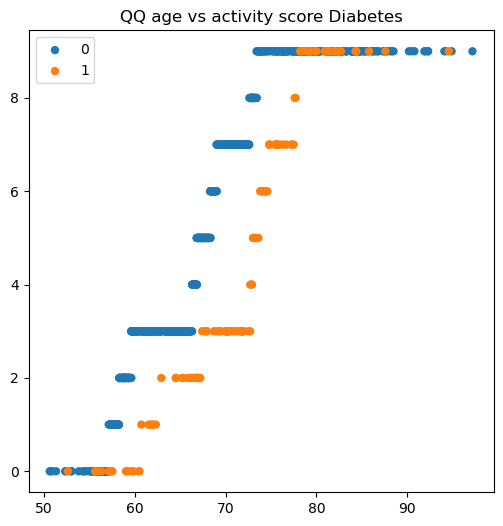

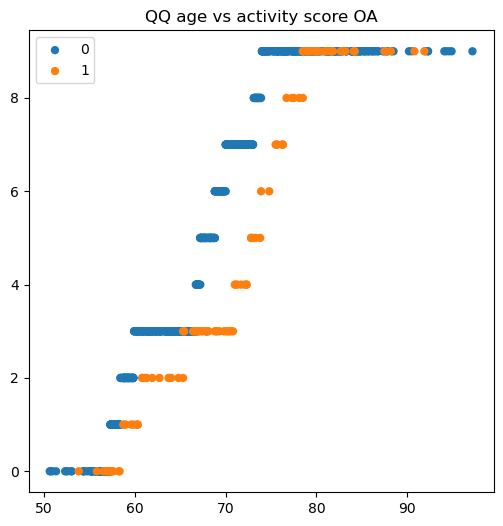

In [91]:
for d in ['Hypertension', 'Diabetes', 'OA']:
    _df = df_stat.dropna(subset=[d, 'age', 'activity'])
    p = qqplot(data=_df, x='age', y='activity', hue=d)
    plt.title(f'QQ age vs activity score {d}')
    plt.show()

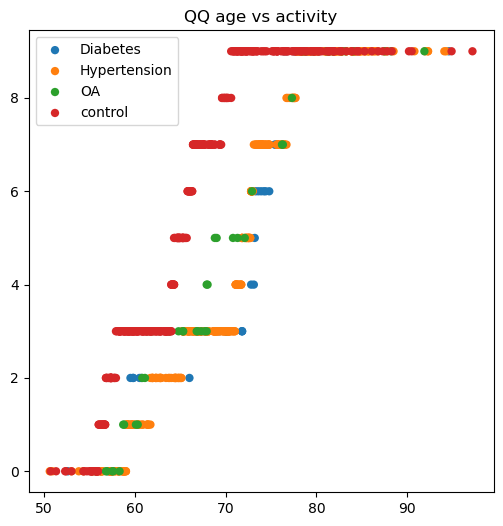

In [79]:
qqplot(data=df_stat, x='age', y='activity', hue='disease')
plt.title('QQ age vs activity')
plt.show()

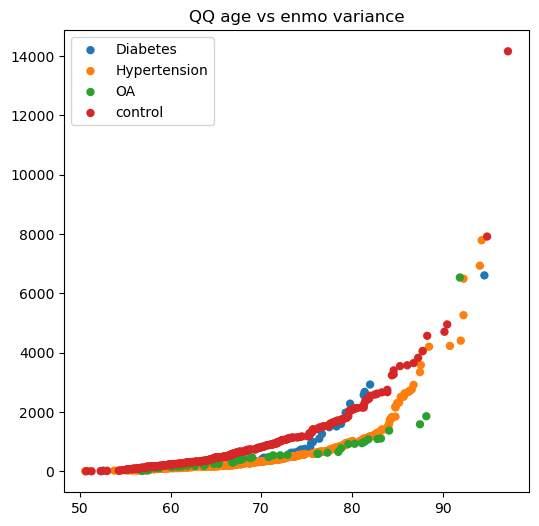

In [80]:
qqplot(data=df_stat, x='age', y='var_ENMO', hue='disease')
plt.title('QQ age vs enmo variance')
plt.show()

In [ ]:
from matplotlib import cm
def qqplot(x, y,palette= cm.viridis, *args, **kwargs):
    _, xr = stats.probplot(x, fit=False)
    _, yr = stats.probplot(y, fit=False)
    sns.scatterplot(x=xr, y=yr, edgecolor="none", palette=palette, *args, **kwargs)

In [ ]:
hue = 'disease'
plt.figure(figsize=[10,10])
g = sns.PairGrid(data=df_stat, vars=[H,_H], hue=hue, dropna=True)
    #with sns.color_palette('viridis', n_colors=len(df_anno[hue].unique())):
g.map_upper(qqplot)
g.map_diag(sns.kdeplot, warn_singular=False)
g.map_lower(sns.scatterplot)

g.fig.suptitle(f'Scatter, KDE and QQ-plot split by hue {hue}', y=1.03, size=25)
g.add_legend(title = hue, title_fontsize='xx-large', fontsize='xx-large', markerscale=2)
#plt.savefig(os.path.join(plot_dir, f'scatter_kde_qq_{hue}.png'))
plt.show()

AttributeError: 'int' object has no attribute 'plot'

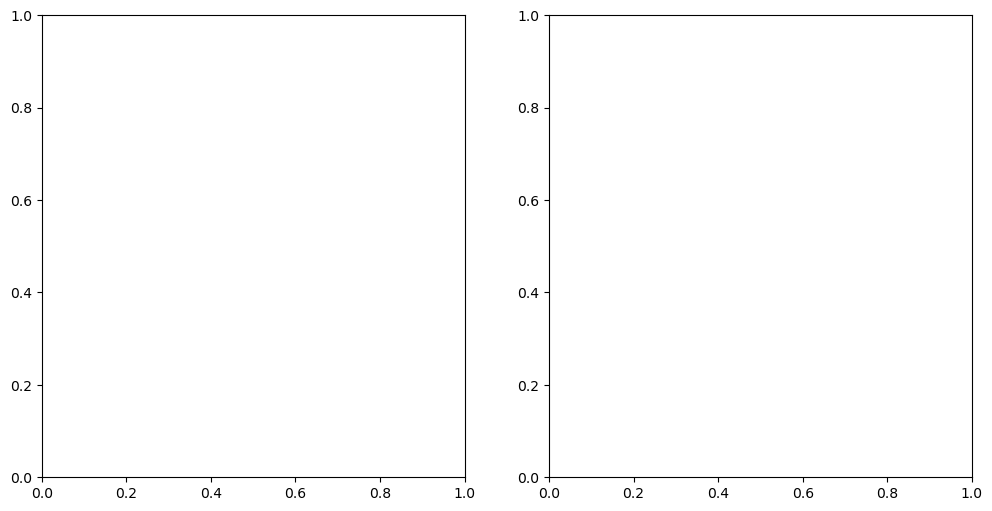

In [32]:
fig, [ax0, ax1] = plt.subplots(1, 2)
fig.set_size_inches([12,6])
sns.regplot(data=df_stat, x="Hypertension", y="activity", ax=0)
sns.residplot(data=df_stat, x="Hypertension", y="activity", ax=1)
plt.show()